(one-pixel)=
# One Pixel Attack

In this notebook we will be using the Adversarial Attack *One Pixel Attack* introduced in the publication {cite}`Su_2019`.
As in {ref}`fgsm` we will use PyTorch.

We will first perform the attack on the CIFAR neural net architecture which works on low resolution and later perform it on the imagenet architecture which supports higher resolution images.

In [2]:
import os
import warnings
from typing import List, Tuple
import glob

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import *
from PIL import Image
from scipy.optimize import differential_evolution

# we import and disable warning messages
warnings.filterwarnings('ignore')

data_folder = os.path.join('data/')
# setting a random seed makes the random number generator deterministic and reproducible
np.random.seed(42)
torch.backends.cudnn.deterministic = True
torch.manual_seed(1)
torch.cuda.manual_seed(1)

## CIFAR-10

In this notebook we will use images from the CIFAR-10 dataset. This dataset consists of 60000 low resolution color images of 32x32 pixels, distributed in 10 different classes, see [here](https://www.cs.toronto.edu/~kriz/cifar.html) for more information about this dataset.

We will download the dataset from torchvision.datasets, and we will also introduce the needed image transformations.

In [3]:
CIFAR10_MEAN = np.array([0.4914, 0.4822, 0.4465])
CIFAR10_STD = np.array([0.2023, 0.1994, 0.2010])

cifar10_transform = Compose([
    ToTensor(),
    Normalize(CIFAR10_MEAN, CIFAR10_STD)
])

# we store the images of the dataset downloaded in the variable testset
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=cifar10_transform)

# we define the size of the groups of images
batch_size = 32

# we use a DataLoader to access to the images
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=0)

CATEGORY_NAMES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print("data loaded")

100.0%


Extracting ./data/cifar-10-python.tar.gz to ./data
data loaded


As models pre-trained on this dataset are not available in torchvision, we will load a model that previously trained on this dataset with the VGG16 network architecture adapted to CIFAR-10 that is the data folder.

In [4]:
class VGG16(nn.Module):
    def __init__(self,):
        super(VGG16, self).__init__()
        self.features = self._make_layers([64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'])
        self.classifier = nn.Linear(512, 10)

    def forward(self, x):
        out = self.features(x)
        out = out.view(out.size(0), -1)
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)

# init the network
net = VGG16()

# As in the previous notebook, we will use cuda support to accelerate the computation if it's available:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('found cuda!')
else:
    device = torch.device('cpu')

net.to(device)

# now load the weigths for the model
pretrained_model = torch.load(os.path.join(data_folder, 'cifvgg16.pth'), map_location=device)
try:
    net.load_state_dict(pretrained_model)  
except:
    # if the pretrained model was trained and saved with DataParallel, we need
    # to add some extra code
    net = torch.nn.DataParallel(net)
    net.load_state_dict(pretrained_model['net'])  
    print('model was trained with nn.DataParallel')

# when we load a model with pytorch, by default it is in train mode
# as we are going to use the model to make predictions we set it with evaluation mode
# with the ; we hide the output that was going to be printed out 
net.eval();

print("Loaded model")

model was trained with nn.DataParallel
Loaded model


We are going to visualize some images from our tesloader

Label 4: deer


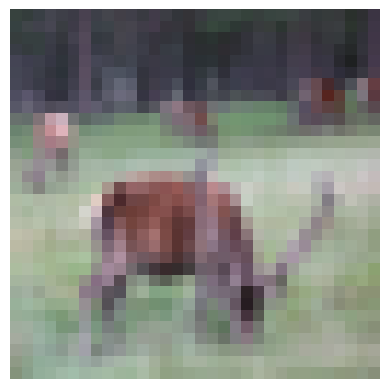

In [5]:
def plot_image(img_tensor: torch.tensor, dataset_mean: np.array = CIFAR10_MEAN, dataset_std: np.array = CIFAR10_STD) -> None:
    img_tensor = img_tensor.permute(1, 2, 0)
    img_np = img_tensor.detach().cpu().numpy()
    
    # _STD[None, None] adds 2 dimensions so we are multiplying the color dimension of the picture
    img_np = (img_np * dataset_std[None,None]) + dataset_mean[None,None]
    img_np = np.clip(img_np, a_min=0.0, a_max=1.0)
    
    # we plot the image 
    plt.figure()
    plt.axis('off')
    plt.imshow(img_np)

# we define an iterator for the testloader
testloader_iterator = iter(testloader)

# we select the first image from the next batch
img_tensors, labels = next(testloader_iterator)
img_tensor = img_tensors[0]
label_tensor = labels[0]

print(f"Label {label_tensor}: {CATEGORY_NAMES[label_tensor]}")
plot_image(img_tensor)

In [6]:
def predict_image(
    img_tensor: torch.tensor,
    model:torchvision.models,
    device: torch.device,
    labels: List[str] = CATEGORY_NAMES,
) -> Tuple[int,str,float]:  
    # create a mini-batch as expected by the model
    # Add an extra batch dimension since pytorch treats all images as batches
    input_batch = img_tensor.unsqueeze(0)
    
    # we send it to the device
    input_batch = input_batch.to(device)
    
    # forward pass, it returns unnormalized scores
    preds = model(input_batch)

    # we use the Softmax function to get the probability distribution over categories
    softmax = torch.nn.functional.softmax(preds, dim=1).cpu().data.numpy()
    pred_idx = preds.cpu().data.numpy().argmax()

    # the use our list of synsets to get the name of the category
    pred_category_name = labels[pred_idx]

    # the function max gives the confidence of predicted category, we round it to 2 digits
    pred_confidence = round(softmax.max()* 100, 2)
  
    return pred_idx, pred_category_name, pred_confidence

pred_idx, pred_label, pred_conf = predict_image(img_tensor, net, device)

print(f'Prediction\t id: {pred_idx}\t category: {pred_label}\t confidence: {pred_conf}%')
print(f'Ground truth\t id: {label_tensor}\t category: {CATEGORY_NAMES[label_tensor]}')

Prediction	 id: 4	 category: deer	 confidence: 99.96%
Ground truth	 id: 4	 category: deer


The One Pixel Adversarial attack, acutually, allows us to define the number of pixels that will be modified. By increasing the number of pixels, we increase the number of chances to perform a successful attack. Although, with low resolution images from CIFAR-10, the chances are quite high with just 1 pixel.

In [7]:
# the number of pixels that will be altered
num_pixels_attacked = 1
targeted = False

# the maximum number of iteration in the DE algorithm
maxiter = 100

#The number of adverisal examples generated in each iteration
population_size = 400
verbose = True
targets = [None] 
target_class = None

Before we attack we need to define the functions which perform the attack.

In [8]:
def perturb_image(info_adv_pixels: list, img_tensor: torch.Tensor, dataset_mean: np.array, dataset_std: np.array) -> torch.Tensor: 
    """
    xs are the info of the pixels that need to be modified, one after another in a list
    for example xs = [ 27.79521332  17.24732404  49.9820024  139.68544107 104.71582841 20.59664589  12.4189431  154.55886261 149.06277258 228.38783138]
    in this example there are 10 values from the 2 pixels that are modified [x,y,r,g,b x,y,r,g,b]
    """
    if info_adv_pixels.ndim < 2:
        info_adv_pixels = np.array([info_adv_pixels])    
    
    # we convert the x,y,r,g,b values to ints
    info_adv_pixels = info_adv_pixels.astype(int)
    for x in info_adv_pixels:
        pixels = np.split(x, len(x)/5)
        # image tensors in a batch: [batch, channels, height, width] 
        # during training there is the batch size that leave to 0 [batch_size, channels, height, width]
        # pixels are modified and normalized with cifar10 or ImageNet mean/std
        for pixel in pixels:
            x_pos, y_pos, r, g, b = pixel
            img_tensor[0, 0, x_pos, y_pos] = (r/255.0-dataset_mean[0])/dataset_std[0]
            img_tensor[0, 1, x_pos, y_pos] = (g/255.0-dataset_mean[1])/dataset_std[1]
            img_tensor[0, 2, x_pos, y_pos] = (b/255.0-dataset_mean[2])/dataset_std[2]
        
    # we return the perturb image
    return img_tensor

In [9]:
def predict_classes(
    info_adv_pixels: List,
    img_tensor: torch.Tensor,
    img_class: int,
    net: nn.Module,
    dataset_mean: np.array,
    dataset_std: np.array,
    targetted_attack: bool = True
):
    """
    this is the function that is passed to DE to evaluate the performance of the generated modifications
    """
    img_perturbed_tensor = perturb_image(
        info_adv_pixels,
        img_tensor.clone(),
        dataset_mean=dataset_mean,
        dataset_std=dataset_std,
    )

    input_img = img_perturbed_tensor.to(device)
    
    predictions = F.softmax(net(input_img)).data.cpu().numpy()[:, img_class]
    
    #Trying to solve warning, but it didn't work
    #predictions = F.softmax(net(input), dim=target_class).data.cpu().numpy()

    return predictions if targetted_attack else 1 - predictions

In [10]:
def attack_success(
    info_adv_pixels: List,
    img_tensor: torch.Tensor,
    label: int,
    net: nn.Module,
    dataset_mean: np.array,
    dataset_std: np.array,
    targeted_attack: bool = False,
    verbose: bool = False
) -> bool:
    """
    returns True if it was a successful attack
    """
    # we call perturb_image for modifying the pixels
    attack_image = perturb_image(info_adv_pixels, img_tensor.clone(), dataset_mean, dataset_std)

    # we send the result image to the GPU
    input_attack_image = attack_image.to(device)    
    
    # we get the probabilities
    #confidence = F.softmax(net(input)).data.cpu().numpy()[0]
    confidence = F.softmax(net(input_attack_image), dim=1).data.cpu().numpy()

    # and the most predicted category
    predicted_class = np.argmax(confidence)

    # if it predicts something else, it worked!!!
    # in this case the predicted_class is the ground truth label
    if predicted_class != label:
        return True
    else:
        return False

In [11]:
def one_pixel_attack(
    img_tensor: torch.tensor,
    label: torch.tensor,
    dataset: str,
    net: nn.Module,
    target: int = None,
    num_pixels_attacked: int = 1,
    maxiter: int = 100,
    population_size: int = 400,
    verbose: bool = False
):
    targeted_attack = target is not None
    
    # depending on the dataset that we use (and also on the neural net architecture), the input images we work with will have different dimensions
    if(dataset == "cifar10"): #The bounds for the 32x32 pixels RGB images from CIFAR-10
        w_and_h = 32
        dataset_mean = CIFAR10_MEAN
        dataset_std = CIFAR10_STD
    elif(dataset == "imagenet"):  #The bounds for the 224x224 pixels RGB images for ImageNet
        w_and_h = 224
        dataset_mean = CIFAR10_MEAN
        dataset_std = CIFAR10_STD
    else:
        raise ValueError("The dataset parameter has to be either cifar10 or imagenet")
    
    # we create a list with the spatial and pixel boundaries
    bounds = [(0,w_and_h), (0,w_and_h), (0,255), (0,255), (0,255)] * num_pixels_attacked
    
    popmul = max(1, population_size/len(bounds))

    # we need to pass two functions to the differential_evolution algorithm, that is the one that finds the pixel modifications
    # for the attack
    
    # we pass our predict_classes function that predicts the category of the image tensor
    predict_fn = lambda xs: predict_classes(
        xs,
        img_tensor,
        label,
        net,
        dataset_mean,
        dataset_std,
        target is None,
    )    
    
    # we pass the function attack_success
    callback_fn = lambda x, convergence: attack_success(
        x,
        img_tensor,
        label,
        net,
        dataset_mean,
        dataset_std,
        targeted_attack,
        verbose,
    )
    
    # we generate a matrix with zeros of the 
    inits = np.zeros([int(popmul*len(bounds)), len(bounds)])
    
    # the initial population is initialized by using uniform distributions for generating the x,y coord:
    # U(1,32) for CIFAR-10 and U(1,224) for ImageNet
    # and gaussian distributions N(128,127) for RGB values
    for init in inits:
        for i in range(num_pixels_attacked):
            init[i*5+0] = np.random.uniform()*w_and_h #x
            init[i*5+1] = np.random.uniform()*w_and_h #y
            init[i*5+2] = np.random.normal(128,127)   #r
            init[i*5+3] = np.random.normal(128,127)   #g
            init[i*5+4] = np.random.normal(128,127)   #b
    
    # scipy's implementation of the differential evolution algorithm
    # this algorithms is the core of this attack. It finds the pixels that lead to a missclassification of the image
    attack_result = differential_evolution(
        predict_fn,
        bounds,
        maxiter=maxiter,
        popsize=popmul,
        recombination=1,
        atol=-1,
        callback=callback_fn,
        polish=False,
        init=inits
    )
    
    # perturb_image applies the pixels modifications stored in attack_result to the input image
    attack_image = perturb_image(attack_result.x, img_tensor, dataset_mean, dataset_std)
    
    # we return the result image and also the pixel modifications
    return attack_image, attack_result.x.astype(int)

We will now perform the attack.

Prediction adversarial	 id: 4	category: deer	 confidence: 95.03%
Ground truth		 id: 4	category: deer
(x,y) = (28,22) and (R,G,B) = (216,0,0)


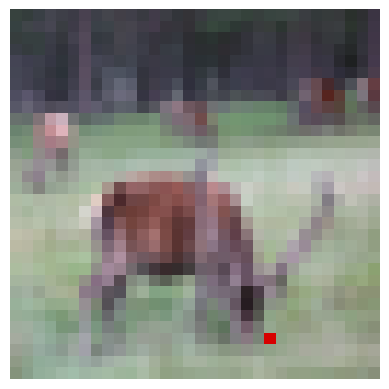

In [12]:
# a candidate solution contains a fixed number of perturbations
# one perturbation is a tuple containing the information for 1 pixel ->  x,y,r,g,b
input_batch = img_tensor.unsqueeze(0)
adv_image, perturbation = one_pixel_attack(img_tensor=input_batch, label=label_tensor,dataset='cifar10', net=net, target=None, num_pixels_attacked=num_pixels_attacked, maxiter=maxiter, population_size=population_size, verbose=verbose)

plot_image(adv_image.squeeze())

pred_adv_idx, pred_adv_label, pred_adv_conf = predict_image(
    adv_image.squeeze(),
    net,
    device
)
p = perturbation
print(f'Prediction adversarial\t id: {pred_adv_idx}\tcategory: {pred_adv_label}\t confidence: {pred_adv_conf}%')
print(f'Ground truth\t\t id: {label_tensor}\tcategory: {CATEGORY_NAMES[label_tensor]}')
print(f"(x,y) = ({p[0]},{p[1]}) and (R,G,B) = ({p[2]},{p[3]},{p[4]})")

We will now randomly select any other image from the dataset

original image (label car)


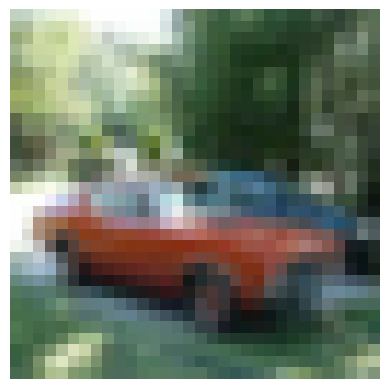

In [13]:
# Get a random sample
random_index = np.random.randint(batch_size)

img_tensor = img_tensors[random_index]
label_tensor = labels[random_index]

print(f"original image (label {CATEGORY_NAMES[label_tensor]})")
plot_image(img_tensor)

In [14]:
# we call the predict image function that passes the image to the model to make a prediction
pred_idx, pred_label, pred_conf = predict_image(img_tensor, net, device)

print(f'Prediction\t id: {pred_idx}\t category: {pred_label}\t confidence: {pred_conf}%')
print(f'Ground truth\t id: {label_tensor}\t category: {CATEGORY_NAMES[label_tensor]}')

Prediction	 id: 1	 category: car	 confidence: 99.91%
Ground truth	 id: 1	 category: car


And we perform the attack again

Prediction adversarial	 id: 9	category: truck	 confidence: 94.73%
Ground truth		 id: 1	category: car
(x,y) = (18,11) and (R,G,B) = (148,30,59)


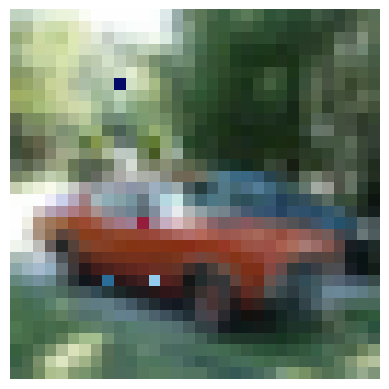

In [15]:
input_batch = img_tensor.unsqueeze(0)

# we try adding more pixels, it will make it easier
num_pixels_attacked = 4


adv_image, perturbation = one_pixel_attack(
    img_tensor=input_batch,
    label=label_tensor,
    dataset='cifar10',
    net=net,
    target=None,
    num_pixels_attacked=num_pixels_attacked,
    maxiter=maxiter,
    population_size=population_size,
    verbose=verbose
)

plot_image(adv_image.squeeze())

pred_adv_idx, pred_adv_label, pred_adv_conf = predict_image(
    adv_image.squeeze(),
    net,
    device
)
p = perturbation
print(f'Prediction adversarial\t id: {pred_adv_idx}\tcategory: {pred_adv_label}\t confidence: {pred_adv_conf}%')
print(f'Ground truth\t\t id: {label_tensor}\tcategory: {CATEGORY_NAMES[label_tensor]}')
print(f"(x,y) = ({p[0]},{p[1]}) and (R,G,B) = ({p[2]},{p[3]},{p[4]})")

## ImageNet

After we have seen how the attack works on low-res images we want to use the ImageNet dataset which has a higher resolution.

In [16]:
images = {}
for file_name in glob.glob(os.path.join(data_folder, 'images', 'dataset', '*')):
    # remove file extension and path
    short_file_name = os.path.splitext(os.path.split(file_name)[-1])[0]
    images[os.path.splitext(short_file_name)[0]] = {
        # Image is from PIL library
        'image': Image.open(file_name)
    }
    print(f"loaded {file_name}")

loaded data/images/dataset/dog.jpg
loaded data/images/dataset/harmonicawood.jpg
loaded data/images/dataset/pineapple.jpg
loaded data/images/dataset/joys.jpg
loaded data/images/dataset/jellyfish.jpg
loaded data/images/dataset/teapot.jpg
loaded data/images/dataset/pizza.jpg
loaded data/images/dataset/bus.jpg
loaded data/images/dataset/pig.jpg
loaded data/images/dataset/bear.jpg


Lets load AlexNet from torchvision. This neural net has been trained on ImageNet.

In [17]:
# define our network architecture
net = torchvision.models.alexnet(pretrained=True, progress=True)

# we set our network to evaluation mode because we won't train ti
net.eval(); 

# we send the network to our GPU device for faster calcualtions
net.to(device)
print("using AlexNet network architecture")

using AlexNet network architecture


In [18]:
# load labels
with open(os.path.join(data_folder, 'synset_words.txt'), 'r') as f:
    synset_words = [' '.join(s.replace('\n', '').split(' ')[1:]) for s in f.readlines()]

np.random.choice(synset_words, 5)

array(['lab coat, laboratory coat', 'borzoi, Russian wolfhound',
       'white stork, Ciconia ciconia',
       'walking stick, walkingstick, stick insect',
       'wallet, billfold, notecase, pocketbook'], dtype='<U121')

As with CIFAR10 we need to respect any pre-processing as well.

In [19]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

preprocess_alexnet = Compose([
    Resize(224),
    CenterCrop(224),
    ToTensor(),
    Normalize(IMAGENET_MEAN, IMAGENET_STD)
])

plot_alexnet = lambda img_tensor: plot_image(img_tensor, IMAGENET_MEAN, IMAGENET_STD)

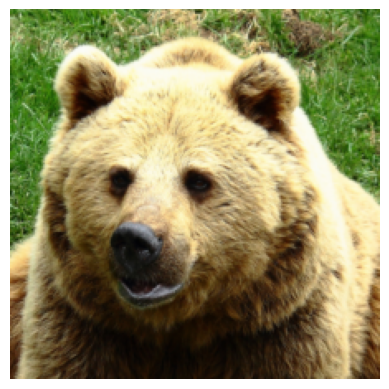

In [20]:
# we pre-process the image and display it
img_tensor = preprocess_alexnet(images['bear']['image'])
plot_alexnet(img_tensor)

We use our network to predict the content of the image

In [21]:
pred_idx, pred_label, pred_conf = predict_image(img_tensor, net, device, synset_words)

print(f'Prediction\t id: {pred_idx}\t category: {pred_label}\t confidence: {pred_conf}%')

Prediction	 id: 294	 category: brown bear, bruin, Ursus arctos	 confidence: 100.0%


With higher resolution images, we probability of having a successful attack is lower. Thus, we will increase the number of modified pixels 

In [22]:
# the number of pixels that will be altered
num_pixels_attacked = 10
targeted = False

# the maximum number of iteration in the DE algorithm
maxiter = 100

#The number of adverisal examples generated in each iteration
population_size = 400
verbose = True
targets = [None] 
target_class = None

We will now perform the attack, and predict again the content of the generated adversarial image

Prediction adversarial	 id: 294	category: brown bear, bruin, Ursus arctos	 confidence: 99.96%
Ground truth		 id: None	category: brown bear, bruin, Ursus arctos
Pertubation 0: (x,y) = (104, 63) and (R,G,B) = (49, 126, 191)
Pertubation 1: (x,y) = (140, 76) and (R,G,B) = (210, 230, 73)
Pertubation 2: (x,y) = (12, 186) and (R,G,B) = (113, 179, 30)
Pertubation 3: (x,y) = (41, 55) and (R,G,B) = (132, 248, 190)
Pertubation 4: (x,y) = (85, 115) and (R,G,B) = (104, 68, 87)
Pertubation 5: (x,y) = (108, 86) and (R,G,B) = (57, 122, 102)
Pertubation 6: (x,y) = (58, 133) and (R,G,B) = (37, 127, 226)
Pertubation 7: (x,y) = (108, 95) and (R,G,B) = (183, 89, 174)
Pertubation 8: (x,y) = (150, 77) and (R,G,B) = (206, 244, 240)
Pertubation 9: (x,y) = (115, 81) and (R,G,B) = (70, 62, 27)


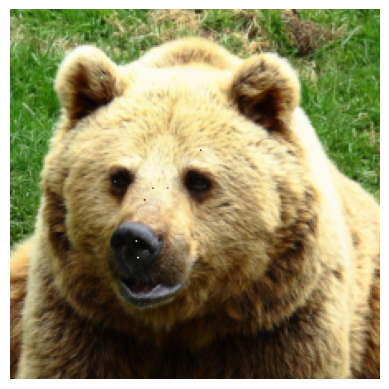

In [23]:
# a candidate solution contains a fixed number of perturbations
# one perturbation is a tuple containing the information for 1 pixel ->  x,y,r,g,b

input_batch = img_tensor.unsqueeze(0)
pred_label_tensor = torch.tensor(pred_idx)

adv_image, perturbation = one_pixel_attack(
    img_tensor=input_batch,
    label=pred_label_tensor,
    dataset='imagenet',
    net=net,
    target=None,
    num_pixels_attacked=num_pixels_attacked,
    maxiter=maxiter,
    population_size=population_size,
    verbose=verbose
)

plot_alexnet(adv_image.squeeze())

pred_adv_idx, pred_adv_label, pred_adv_conf = predict_image(
    adv_image.squeeze(),
    net,
    device,
    synset_words,
)

print(f'Prediction adversarial\t id: {pred_adv_idx}\tcategory: {pred_adv_label}\t confidence: {pred_adv_conf}%')
print(f'Ground truth\t\t id: {None}\tcategory: {synset_words[pred_idx]}')

for i, p in enumerate(np.array(perturbation).reshape(-1, 5).tolist()):
    print(f"Pertubation {i}: (x,y) = ({p[0]}, {p[1]}) and (R,G,B) = ({p[2]}, {p[3]}, {p[4]})")

## References


* [One pixel attack for fooling deep neural networks](https://arxiv.org/abs/1710.08864)
* [A tutorial on Differential Evolution with Python](https://pablormier.github.io/2017/09/05/a-tutorial-on-differential-evolution-with-python/)
* [3 practical examples for tricking Neural Networks using GA and FGSM. How can object classification be easily fooled?](https://medium.com/profil-software-blog/few-practical-examples-of-cheating-ai-models-including-ga-genetic-algorithm-and-fgsm-fast-c522da8938af)
* [CIFAR-10 train](https://github.com/cgnorthcutt/cleanlab/blob/master/examples/cifar10/cifar10_train_crossval.py)
* [CIFAR-10 Classifier Using CNN in PyTorch](https://www.stefanfiott.com/machine-learning/cifar-10-classifier-using-cnn-in-pytorch/)

### Bibliography

```{bibliography}
:filter: docname in docnames
```